## Import Statements

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

## Read in Data

In [2]:
df = pd.read_csv('data/preprocessed_log_data.csv')
df = df[df['Label'] == 1];
df.drop(columns=['Label', 'TaskName', 'Transmission', 'IsHybrid', 'DriveType'], inplace=True) # Drop TaskName as all are 'Logbook'
df.head()

,Odometer,Make,Model,Year,FuelType,EngineSize,Distance,Months,AdjustedPrice
1,72199.0,SKODA,SKODA FABIA III,2017,Petrol,1.0,75000.0,60.0,710.0
4,81168.0,MAZDA,MAZDA CX-9,2018,Petrol,2.5,80000.0,96.0,586.0
5,33541.0,MAZDA,MAZDA 3,2017,Petrol,2.0,60000.0,72.0,384.0
6,54040.0,TOYOTA,TOYOTA HILUX,2015,Diesel,2.8,60000.0,36.0,477.0
8,40557.0,FORD,FORD RANGER,2021,Diesel,2.0,45000.0,36.0,656.0


In [3]:
df['Distance'] = df['Distance'].fillna(df['Odometer'])
df.drop(columns=['Odometer'], inplace=True)

In [4]:
model_counts = df['Model'].value_counts()

# Keep only models that appear at least 10 times
models_to_keep = model_counts[model_counts >= 10].index

# Filter the DataFrame
df = df[df['Model'].isin(models_to_keep)]

In [5]:
X = df.drop(columns=["AdjustedPrice"])  
y = df["AdjustedPrice"]       
cat_feature_indices = [0, 1, 3]

In [6]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42
)
X_test, X_val, y_test, y_val = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

In [7]:
for col in X_train.select_dtypes(include='object').columns:
     X_train[col] = X_train[col].fillna("missing")

for col in X_val.select_dtypes(include='object').columns:
   X_val[col] = X_val[col].fillna("missing")

for col in X_test.select_dtypes(include='object').columns:
   X_test[col] = X_test[col].fillna("missing")

In [8]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Avoid division by zero
    nonzero_mask = y_true != 0
    return np.mean(np.abs((y_true[nonzero_mask] - y_pred[nonzero_mask]) / y_true[nonzero_mask])) * 100

In [9]:
model = CatBoostRegressor(
    eval_metric='MAPE',
    loss_function='RMSEWithUncertainty',
    od_type='Iter',
    od_wait=50,
    random_seed=42,
    verbose=0,
    thread_count=4
)

param_grid = {
    'depth': [6, 8, 10],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'l2_leaf_reg': [1, 3, 5, 7],
    'iterations': [1000, 1500],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bylevel': [0.8, 0.9, 1.0],
    'min_child_samples': [5, 10, 20],
}


random_search = RandomizedSearchCV(
    model,
    param_distributions=param_grid,
    n_iter=25,            
    cv=3,                 
    scoring='neg_mean_absolute_percentage_error',
    random_state=42,
    verbose=2,
    n_jobs=-1
)

In [10]:
random_search.fit(
    X_train, y_train,
    cat_features=cat_feature_indices,
    early_stopping_rounds=200
)

print("Best params:", random_search.best_params_)
print("Best CV score (MAPE):", -random_search.best_score_)

Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV] END colsample_bylevel=0.9, depth=8, iterations=1000, l2_leaf_reg=7, learning_rate=0.1, min_child_samples=20, subsample=0.9; total time= 9.0min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.9, depth=8, iterations=1000, l2_leaf_reg=7, learning_rate=0.1, min_child_samples=20, subsample=0.9; total time= 9.2min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.9, depth=8, iterations=1000, l2_leaf_reg=7, learning_rate=0.1, min_child_samples=20, subsample=0.9; total time= 9.3min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.9, depth=6, iterations=1500, l2_leaf_reg=5, learning_rate=0.03, min_child_samples=20, subsample=0.8; total time= 9.8min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.9, depth=6, iterations=1500, l2_leaf_reg=7, learning_rate=0.03, min_child_samples=10, subsample=1.0; total time= 9.9min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.9, depth=6, iterations=1500, l2_leaf_reg=5, learning_rate=0.03, min_child_samples=20, subsample=0.8; total time= 9.9min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.9, depth=6, iterations=1500, l2_leaf_reg=7, learning_rate=0.03, min_child_samples=10, subsample=1.0; total time=10.0min
[CV] END colsample_bylevel=0.9, depth=6, iterations=1500, l2_leaf_reg=5, learning_rate=0.03, min_child_samples=20, subsample=0.8; total time= 9.9min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.9, depth=6, iterations=1500, l2_leaf_reg=7, learning_rate=0.03, min_child_samples=10, subsample=1.0; total time= 9.9min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=1.0, depth=8, iterations=1500, l2_leaf_reg=1, learning_rate=0.03, min_child_samples=5, subsample=0.8; total time=14.2min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.8, depth=10, iterations=1500, l2_leaf_reg=7, learning_rate=0.1, min_child_samples=10, subsample=1.0; total time=18.4min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.8, depth=10, iterations=1500, l2_leaf_reg=7, learning_rate=0.1, min_child_samples=10, subsample=1.0; total time=18.6min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.8, depth=8, iterations=1000, l2_leaf_reg=3, learning_rate=0.01, min_child_samples=20, subsample=0.8; total time= 8.9min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.9, depth=10, iterations=1500, l2_leaf_reg=3, learning_rate=0.05, min_child_samples=5, subsample=0.8; total time=19.1min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.9, depth=8, iterations=1000, l2_leaf_reg=5, learning_rate=0.03, min_child_samples=10, subsample=1.0; total time= 9.2min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.9, depth=8, iterations=1000, l2_leaf_reg=5, learning_rate=0.03, min_child_samples=10, subsample=1.0; total time= 9.2min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.9, depth=8, iterations=1000, l2_leaf_reg=5, learning_rate=0.03, min_child_samples=10, subsample=1.0; total time= 9.3min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.8, depth=10, iterations=1500, l2_leaf_reg=7, learning_rate=0.1, min_child_samples=10, subsample=1.0; total time=19.3min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.9, depth=10, iterations=1500, l2_leaf_reg=3, learning_rate=0.05, min_child_samples=5, subsample=0.8; total time=19.3min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.9, depth=10, iterations=1500, l2_leaf_reg=3, learning_rate=0.05, min_child_samples=5, subsample=0.8; total time=19.5min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.8, depth=8, iterations=1000, l2_leaf_reg=3, learning_rate=0.01, min_child_samples=20, subsample=0.8; total time= 8.9min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=1.0, depth=8, iterations=1500, l2_leaf_reg=1, learning_rate=0.03, min_child_samples=5, subsample=0.8; total time=14.2min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.8, depth=8, iterations=1500, l2_leaf_reg=1, learning_rate=0.1, min_child_samples=20, subsample=0.9; total time=14.0min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.8, depth=8, iterations=1500, l2_leaf_reg=1, learning_rate=0.1, min_child_samples=20, subsample=0.9; total time=13.6min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=1.0, depth=8, iterations=1500, l2_leaf_reg=1, learning_rate=0.03, min_child_samples=5, subsample=0.8; total time=14.4min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.8, depth=8, iterations=1500, l2_leaf_reg=1, learning_rate=0.1, min_child_samples=20, subsample=0.9; total time=13.9min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.8, depth=6, iterations=1000, l2_leaf_reg=7, learning_rate=0.05, min_child_samples=10, subsample=0.9; total time= 6.6min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.8, depth=6, iterations=1000, l2_leaf_reg=7, learning_rate=0.05, min_child_samples=10, subsample=0.9; total time= 6.5min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.8, depth=6, iterations=1000, l2_leaf_reg=7, learning_rate=0.05, min_child_samples=10, subsample=0.9; total time= 6.7min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.8, depth=8, iterations=1000, l2_leaf_reg=3, learning_rate=0.01, min_child_samples=20, subsample=0.8; total time= 8.9min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=1.0, depth=8, iterations=1000, l2_leaf_reg=7, learning_rate=0.03, min_child_samples=5, subsample=1.0; total time= 9.6min
[CV] END colsample_bylevel=1.0, depth=8, iterations=1000, l2_leaf_reg=7, learning_rate=0.03, min_child_samples=5, subsample=1.0; total time= 9.6min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=1.0, depth=8, iterations=1000, l2_leaf_reg=7, learning_rate=0.03, min_child_samples=5, subsample=1.0; total time= 9.6min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.9, depth=10, iterations=1000, l2_leaf_reg=3, learning_rate=0.01, min_child_samples=20, subsample=0.8; total time=12.7min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.9, depth=10, iterations=1000, l2_leaf_reg=3, learning_rate=0.01, min_child_samples=20, subsample=0.8; total time=12.8min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.9, depth=10, iterations=1000, l2_leaf_reg=3, learning_rate=0.01, min_child_samples=20, subsample=0.8; total time=12.7min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=1.0, depth=10, iterations=1000, l2_leaf_reg=5, learning_rate=0.03, min_child_samples=20, subsample=0.8; total time=12.7min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=1.0, depth=10, iterations=1000, l2_leaf_reg=5, learning_rate=0.03, min_child_samples=20, subsample=0.8; total time=12.9min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=1.0, depth=10, iterations=1000, l2_leaf_reg=5, learning_rate=0.03, min_child_samples=20, subsample=0.8; total time=12.7min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.9, depth=10, iterations=1000, l2_leaf_reg=5, learning_rate=0.01, min_child_samples=10, subsample=0.8; total time=11.9min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.9, depth=8, iterations=1000, l2_leaf_reg=3, learning_rate=0.1, min_child_samples=5, subsample=0.8; total time= 8.8min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.9, depth=10, iterations=1000, l2_leaf_reg=5, learning_rate=0.01, min_child_samples=10, subsample=0.8; total time=12.0min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.9, depth=10, iterations=1000, l2_leaf_reg=5, learning_rate=0.01, min_child_samples=10, subsample=0.8; total time=12.2min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=1.0, depth=10, iterations=1000, l2_leaf_reg=7, learning_rate=0.05, min_child_samples=10, subsample=0.8; total time=12.8min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.8, depth=10, iterations=1500, l2_leaf_reg=3, learning_rate=0.03, min_child_samples=10, subsample=0.9; total time=18.6min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.8, depth=10, iterations=1500, l2_leaf_reg=3, learning_rate=0.03, min_child_samples=10, subsample=0.9; total time=18.7min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.8, depth=10, iterations=1500, l2_leaf_reg=3, learning_rate=0.03, min_child_samples=10, subsample=0.9; total time=18.8min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.9, depth=10, iterations=1500, l2_leaf_reg=5, learning_rate=0.1, min_child_samples=5, subsample=1.0; total time=19.8min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.9, depth=10, iterations=1500, l2_leaf_reg=5, learning_rate=0.1, min_child_samples=5, subsample=1.0; total time=20.0min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.9, depth=10, iterations=1500, l2_leaf_reg=5, learning_rate=0.1, min_child_samples=5, subsample=1.0; total time=20.0min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=1.0, depth=10, iterations=1000, l2_leaf_reg=7, learning_rate=0.05, min_child_samples=10, subsample=0.8; total time=12.9min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=1.0, depth=10, iterations=1000, l2_leaf_reg=7, learning_rate=0.05, min_child_samples=10, subsample=0.8; total time=13.2min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.9, depth=6, iterations=1000, l2_leaf_reg=5, learning_rate=0.05, min_child_samples=5, subsample=0.9; total time= 6.8min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.9, depth=6, iterations=1000, l2_leaf_reg=5, learning_rate=0.05, min_child_samples=5, subsample=0.9; total time= 6.8min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.9, depth=6, iterations=1000, l2_leaf_reg=5, learning_rate=0.05, min_child_samples=5, subsample=0.9; total time= 6.9min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.9, depth=8, iterations=1000, l2_leaf_reg=3, learning_rate=0.1, min_child_samples=5, subsample=0.8; total time= 9.3min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.9, depth=8, iterations=1000, l2_leaf_reg=3, learning_rate=0.1, min_child_samples=5, subsample=0.8; total time= 9.6min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.8, depth=6, iterations=1000, l2_leaf_reg=1, learning_rate=0.05, min_child_samples=10, subsample=0.8; total time= 6.5min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.8, depth=6, iterations=1000, l2_leaf_reg=1, learning_rate=0.05, min_child_samples=10, subsample=0.8; total time= 6.5min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.9, depth=8, iterations=1000, l2_leaf_reg=1, learning_rate=0.1, min_child_samples=10, subsample=1.0; total time= 9.7min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.9, depth=8, iterations=1000, l2_leaf_reg=1, learning_rate=0.1, min_child_samples=10, subsample=1.0; total time= 9.7min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.8, depth=6, iterations=1000, l2_leaf_reg=1, learning_rate=0.05, min_child_samples=10, subsample=0.8; total time= 6.5min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.9, depth=8, iterations=1000, l2_leaf_reg=1, learning_rate=0.1, min_child_samples=10, subsample=1.0; total time= 9.8min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=1.0, depth=10, iterations=1000, l2_leaf_reg=1, learning_rate=0.05, min_child_samples=5, subsample=1.0; total time=13.5min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=1.0, depth=10, iterations=1000, l2_leaf_reg=1, learning_rate=0.05, min_child_samples=5, subsample=1.0; total time=13.6min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=1.0, depth=10, iterations=1000, l2_leaf_reg=1, learning_rate=0.05, min_child_samples=5, subsample=1.0; total time=13.6min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.8, depth=8, iterations=1500, l2_leaf_reg=1, learning_rate=0.1, min_child_samples=5, subsample=0.8; total time=12.9min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.8, depth=8, iterations=1500, l2_leaf_reg=1, learning_rate=0.1, min_child_samples=5, subsample=0.8; total time=13.3min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.8, depth=8, iterations=1500, l2_leaf_reg=1, learning_rate=0.1, min_child_samples=5, subsample=0.8; total time=13.0min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=1.0, depth=8, iterations=1500, l2_leaf_reg=7, learning_rate=0.1, min_child_samples=10, subsample=1.0; total time=11.9min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=1.0, depth=8, iterations=1500, l2_leaf_reg=7, learning_rate=0.1, min_child_samples=10, subsample=1.0; total time=11.2min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=1.0, depth=8, iterations=1500, l2_leaf_reg=7, learning_rate=0.1, min_child_samples=10, subsample=1.0; total time=11.1min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.8, depth=10, iterations=1500, l2_leaf_reg=1, learning_rate=0.1, min_child_samples=5, subsample=0.8; total time=12.5min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.8, depth=10, iterations=1500, l2_leaf_reg=1, learning_rate=0.1, min_child_samples=5, subsample=0.8; total time=10.7min


/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scorin

[CV] END colsample_bylevel=0.8, depth=10, iterations=1500, l2_leaf_reg=1, learning_rate=0.1, min_child_samples=5, subsample=0.8; total time=10.4min
Best params: {'subsample': 1.0, 'min_child_samples': 10, 'learning_rate': 0.1, 'l2_leaf_reg': 7, 'iterations': 1500, 'depth': 10, 'colsample_bylevel': 0.8}
Best CV score (MAPE): nan


In [11]:
best_params = random_search.best_params_

best_model = CatBoostRegressor(
    **best_params,
    cat_features=cat_feature_indices,
    eval_metric='MAPE',
    random_seed=42,
    verbose=100
)

best_model.fit(
    X_train, y_train,
    eval_set=(X_val, y_val),
    use_best_model=True,
    early_stopping_rounds=200
)

0:	learn: 0.3642721	test: 0.3881007	best: 0.3881007 (0)	total: 71.2ms	remaining: 1m 46s
100:	learn: 0.1975562	test: 0.2166657	best: 0.2166657 (100)	total: 5.51s	remaining: 1m 16s
200:	learn: 0.1836784	test: 0.2042403	best: 0.2042403 (200)	total: 10.9s	remaining: 1m 10s
300:	learn: 0.1786763	test: 0.2007749	best: 0.2007749 (300)	total: 17s	remaining: 1m 7s
400:	learn: 0.1753213	test: 0.1986571	best: 0.1986571 (400)	total: 20.9s	remaining: 57.3s
500:	learn: 0.1722534	test: 0.1965435	best: 0.1965435 (500)	total: 24.4s	remaining: 48.7s
600:	learn: 0.1702265	test: 0.1953207	best: 0.1953207 (600)	total: 28.1s	remaining: 42.1s
700:	learn: 0.1685481	test: 0.1944144	best: 0.1944138 (696)	total: 32.3s	remaining: 36.8s
800:	learn: 0.1671177	test: 0.1935086	best: 0.1935086 (800)	total: 35.8s	remaining: 31.3s
900:	learn: 0.1657252	test: 0.1927492	best: 0.1927491 (898)	total: 40s	remaining: 26.6s
1000:	learn: 0.1644155	test: 0.1925529	best: 0.1924318 (964)	total: 43.7s	remaining: 21.8s
1100:	learn: 

In [12]:
y_pred = best_model.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"MAPE: {mape:.2f}%")

MAE: 92.24721801261886
RMSE: 154.71174544787067
MAPE: 17.29%


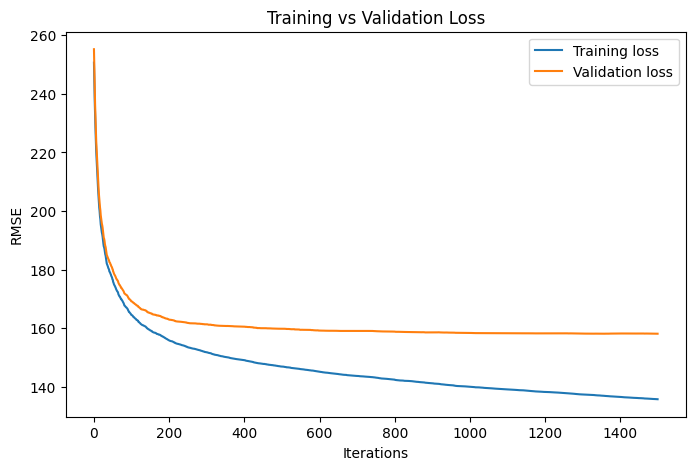

In [13]:
evals_result = best_model.get_evals_result()

# Plot loss curves
plt.figure(figsize=(8,5))
plt.plot(evals_result['learn']['RMSE'], label='Training loss')
plt.plot(evals_result['validation']['RMSE'], label='Validation loss')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()

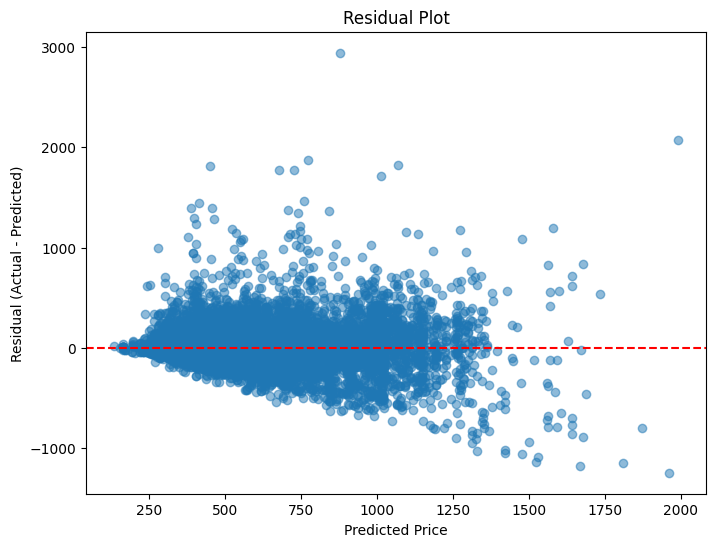

In [14]:
residuals = y_test - y_pred
plt.figure(figsize=(8,6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Price")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residual Plot")
plt.show()

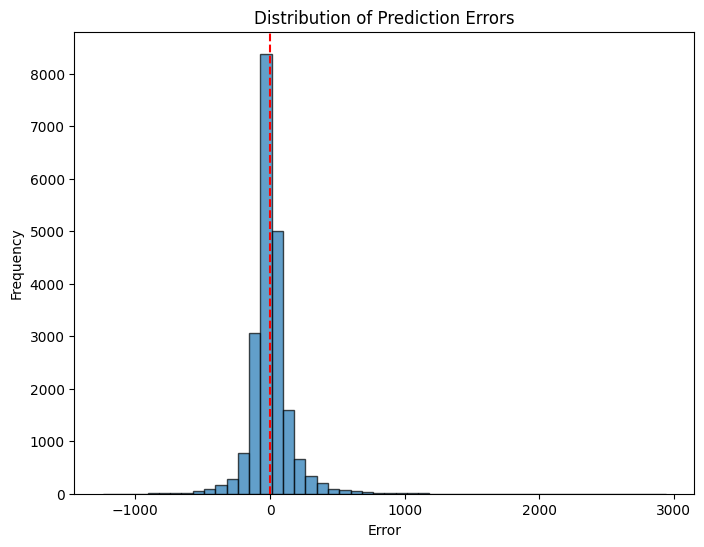

In [15]:
plt.figure(figsize=(8,6))
plt.hist(residuals, bins=50, edgecolor='k', alpha=0.7)
plt.axvline(0, color='red', linestyle='--')
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.title("Distribution of Prediction Errors")
plt.show()

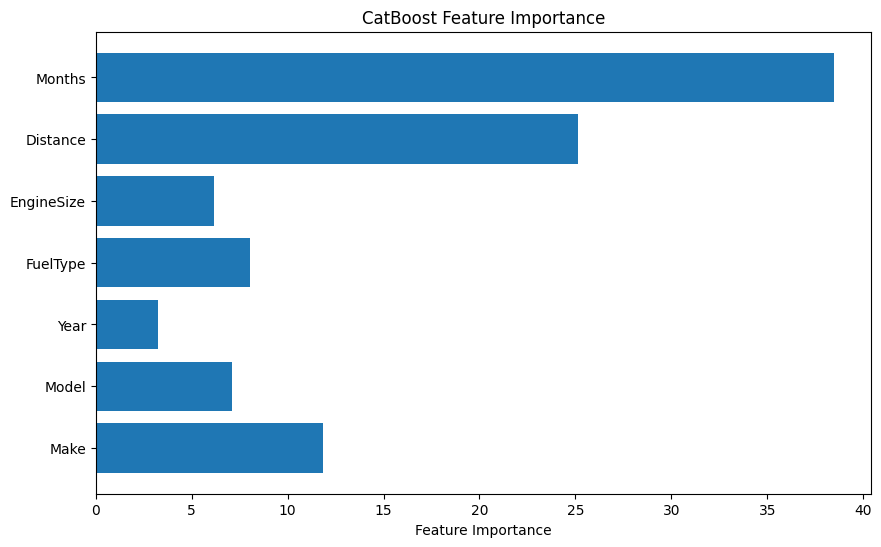

In [16]:
importance = best_model.get_feature_importance()
feature_names = X_train.columns  # or your list of feature names

plt.figure(figsize=(10,6))
plt.barh(feature_names, importance)
plt.xlabel('Feature Importance')
plt.title('CatBoost Feature Importance')
plt.show()

/home/dylan/git/CAPSTONE_T316/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


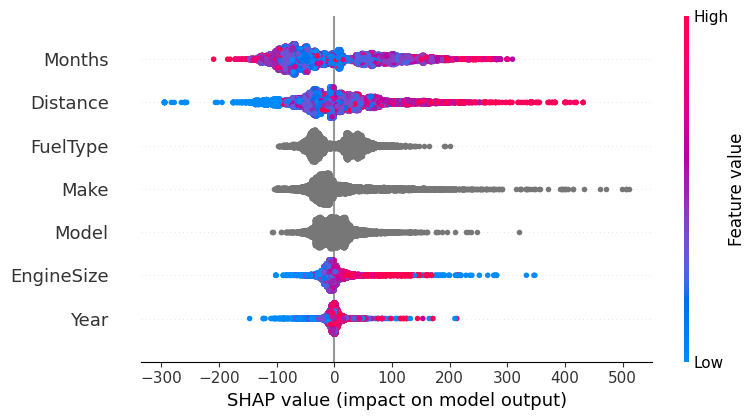

In [17]:
import shap

explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)


In [18]:
best_model.save_model('models/logbook_model.cbm')